In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random

from sklearn.preprocessing import OneHotEncoder
from keras import layers
#from keras.layers import Input, Dense, Activation, Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils import plot_model
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1
np.random.seed(5)
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [2]:
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17505293056418702392
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7880757343399939470
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3046847284
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14771074576768593826
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12543404174442539188
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#importing the data
train = scipy.io.loadmat('train_32x32.mat')

In [6]:
train_x = train['X']
train_y = train['y']

In [89]:
extra = scipy.io.loadmat('extra_32x32.mat')

In [8]:
extra_x = extra['X']
extra_y = extra['y']

In [9]:
extra_x.shape

(32, 32, 3, 531131)

In [10]:
extra_y.shape

(531131, 1)

In [16]:
train_x.shape

(273257, 32, 32, 3)

In [12]:
extra_x = extra_x[:,:,:,:200000]
extra_y = extra_y[:200000,:]

In [13]:
extra = None
del extra

In [14]:
train_x = np.moveaxis(train_x, -1, 0)

extra_x = np.moveaxis(extra_x, -1, 0)


In [15]:
train_x = np.vstack((train_x, extra_x))
train_y = np.vstack((train_y, extra_y))

In [17]:
train_x = train_x.astype('float64')
train_x /= 255.0

In [15]:
temp = int(len(train_x) / 4)

train_x_1 = train_x[:temp]
train_x_2 = train_x [temp: 2*temp]
train_x_3 = train_x [2*temp: 3*temp]
train_x_4 = train_x [3*temp: ]

In [18]:
def cropandUpsampleImage (X):
    
    X = tf.image.crop_to_bounding_box(
    X, 1, 6, 25, 22)
    
    X = tf.image.resize(
    X, [32,32], method='bilinear', preserve_aspect_ratio=False,
    antialias=False)
    
    return X
    


In [19]:
#Since this is a memory intensive process, process images in chunks
temp = int(len(train_x) / 20)
for i in range (0, len(train_x), int(len(train_x) / 20) ):
    
    train_x[i:i+temp] = cropandUpsampleImage(train_x[i:i+temp])

In [23]:
from sklearn.preprocessing import LabelBinarizer
train_labels = train_y.astype('int64')
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)

In [20]:
train_x.shape

(273257, 32, 32, 3)

In [24]:
train_labels.shape

(273257, 10)

In [26]:
train_x = np.array(train_x)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_labels,
                                                  test_size=0.15, random_state=22)

In [37]:
#Importing the test set
test = scipy.io.loadmat('test_32x32.mat')
test_x = test['X']
test_y = test['y']

test_x = test_x.astype('float64')
test_x /= 255.0

test_x = np.moveaxis(test_x, -1, 0)

test_x = tf.image.crop_to_bounding_box(
    test_x , 1, 6, 25, 22
)
test_x  = tf.image.resize(
   test_x , [32,32], method='bilinear', preserve_aspect_ratio=False,
    antialias=False
)

from sklearn.preprocessing import LabelBinarizer
test_labels = test_y.astype('int64')
lb = LabelBinarizer()
test_labels = lb.fit_transform(test_labels)

In [40]:
def convBlock (X, filters, kernel_size, initializer = glorot_uniform, training = True):
    
    X = Conv2D (filters=filters, kernel_size = kernel_size, strides = 1, padding = "same", kernel_initializer = initializer(seed=10))(X)
    X = BatchNormalization(axis=3)(X, training = False)
    X = Activation ('relu') (X)
    
    return X

In [43]:
def createCustomModel(input_shape=(32,32,3), num_classes = 10):
    
    X_input = Input(input_shape)
    
    X = convBlock(X_input,32,(3,3))
    
    X = convBlock(X,64,(3,3))
    
    X = convBlock(X,128,(3,3))
    
    
    X = Flatten(name='flatten')(X)
    X = Dense(256, activation='relu', name='fc1')(X)
    X = Dropout(0.2,seed=10)(X)
    X = Dense(128, activation='relu', name='fc2')(X)
    X = Dropout(0.3,seed=10)(X)
    X = Dense(64, activation='relu', name='fc3')(X)
    X = Dropout(0.2,seed=10)(X)
    X = Dense(num_classes, activation='softmax', name='predictions')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model
    

In [44]:
my_model = createCustomModel(input_shape=(32,32,3), num_classes = 10)
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history_my_model = my_model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=60, validation_data=(X_val, y_val),
                               callbacks=[early_stopping,reduce_lr])

Epoch 1/60
686/686 [==============================] - 42s 61ms/step - loss: 1.6398 - accuracy: 0.4289 - val_loss: 0.5828 - val_accuracy: 0.8226
Epoch 2/60
686/686 [==============================] - 41s 60ms/step - loss: 0.7264 - accuracy: 0.7771 - val_loss: 0.4180 - val_accuracy: 0.8738
Epoch 3/60
686/686 [==============================] - 41s 60ms/step - loss: 0.5730 - accuracy: 0.8271 - val_loss: 0.3522 - val_accuracy: 0.8953
Epoch 4/60
686/686 [==============================] - 41s 60ms/step - loss: 0.5154 - accuracy: 0.8447 - val_loss: 0.3304 - val_accuracy: 0.9012
Epoch 5/60
686/686 [==============================] - 41s 60ms/step - loss: 0.4768 - accuracy: 0.8574 - val_loss: 0.3188 - val_accuracy: 0.9040
Epoch 6/60
686/686 [==============================] - 41s 60ms/step - loss: 0.4480 - accuracy: 0.8672 - val_loss: 0.3065 - val_accuracy: 0.9095
Epoch 7/60
686/686 [==============================] - 42s 61ms/step - loss: 0.4301 - accuracy: 0.8732 - val_loss: 0.3196 - val_accuracy:

In [26]:
def importVGG (num_trainable_layers):

    model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

    if num_trainable_layers == 0:
        for layer in model_vgg16_conv.layers:
            layer.trainable = False

    for layer in model_vgg16_conv.layers[:(-1*num_trainable_layers)]:
        layer.trainable=False
        
    return model_vgg16_conv

In [29]:
def createVGG16Model(train_images, trainable_layers):

    base_model = importVGG(trainable_layers)
    img_shape = train_images.shape[1:]
    num_classes = 10
    #Create your own input formats
    keras_input = Input(shape=img_shape, name = 'image_input')

    #Use the generated model 
    output_vgg16_conv = base_model(keras_input)

    # Add the fully-connected layers 
    My_vgg16 = Flatten(name='flatten')(output_vgg16_conv)
    My_vgg16 = Dense(512, activation='relu', name='fc1')(My_vgg16)
    My_vgg16 = Dropout(0.2,seed=10)(My_vgg16)
    My_vgg16 = Dense(256, activation='relu', name='fc2')(My_vgg16)
    My_vgg16 = Dropout(0.3,seed=10)(My_vgg16)
    My_vgg16 = Dense(64, activation='relu', name='fc3')(My_vgg16)
    My_vgg16 = Dropout(0.2,seed=10)(My_vgg16)
    My_vgg16 = Dense(num_classes, activation='softmax', name='predictions')(My_vgg16)

    #Create your own model 
    model = Model(inputs=keras_input, outputs=My_vgg16)
    return model

In [30]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [134]:
optimizer = tf.keras.optimizers.Adam(amsgrad = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
vgg_model = createVGG16Model(X_train,12)

vgg_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history = vgg_model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=50, validation_data=(X_val, y_val),
                               callbacks=[early_stopping])

Epoch 1/50
686/686 [==============================] - 46s 66ms/step - loss: 1.3060 - accuracy: 0.5456 - val_loss: 0.5416 - val_accuracy: 0.8425
Epoch 2/50
686/686 [==============================] - 46s 67ms/step - loss: 0.4977 - accuracy: 0.8687 - val_loss: 0.3697 - val_accuracy: 0.8988
Epoch 3/50
686/686 [==============================] - 46s 68ms/step - loss: 0.4002 - accuracy: 0.8940 - val_loss: 0.2977 - val_accuracy: 0.9198
Epoch 4/50
686/686 [==============================] - 48s 69ms/step - loss: 0.3506 - accuracy: 0.9068 - val_loss: 0.2691 - val_accuracy: 0.9259
Epoch 5/50
686/686 [==============================] - 48s 70ms/step - loss: 0.3210 - accuracy: 0.9158 - val_loss: 0.2749 - val_accuracy: 0.9287
Epoch 6/50
686/686 [==============================] - 48s 70ms/step - loss: 0.3034 - accuracy: 0.9203 - val_loss: 0.2931 - val_accuracy: 0.9181
Epoch 7/50
686/686 [==============================] - 48s 70ms/step - loss: 0.2859 - accuracy: 0.9253 - val_loss: 0.2596 - val_accuracy:

In [135]:

preds_st = vgg_model.evaluate(x= test_x, y=test_labels,  batch_size=128)
print()
print ("Loss = " + str(preds_st[0]))
print ("Test Accuracy = " + str(preds_st[1]))

204/204 [==============================] - 4s 20ms/step - loss: 0.2462 - accuracy: 0.9403

Loss = 0.2461944967508316
Test Accuracy = 0.9403426647186279


In [144]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
optimizer = tf.keras.optimizers.Adam(amsgrad = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
vgg_model_reduce_lr = createVGG16Model(X_train,12)

vgg_model_reduce_lr.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history = vgg_model_reduce_lr.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=50, validation_data=(X_val, y_val),
                               callbacks=[early_stopping,reduce_lr])

Epoch 1/50
686/686 [==============================] - 48s 70ms/step - loss: 1.2832 - accuracy: 0.5735 - val_loss: 0.5664 - val_accuracy: 0.8351
Epoch 2/50
686/686 [==============================] - 48s 71ms/step - loss: 0.4955 - accuracy: 0.8662 - val_loss: 0.3493 - val_accuracy: 0.9034
Epoch 3/50
686/686 [==============================] - 49s 71ms/step - loss: 0.3962 - accuracy: 0.8937 - val_loss: 0.2869 - val_accuracy: 0.9188
Epoch 4/50
686/686 [==============================] - 49s 71ms/step - loss: 0.3518 - accuracy: 0.9071 - val_loss: 0.2912 - val_accuracy: 0.9194
Epoch 5/50
686/686 [==============================] - 49s 72ms/step - loss: 0.3283 - accuracy: 0.9142 - val_loss: 0.2779 - val_accuracy: 0.9269
Epoch 6/50
686/686 [==============================] - 50s 73ms/step - loss: 0.2946 - accuracy: 0.9224 - val_loss: 0.2477 - val_accuracy: 0.9327
Epoch 7/50
686/686 [==============================] - 50s 73ms/step - loss: 0.2798 - accuracy: 0.9271 - val_loss: 0.2450 - val_accuracy:

In [99]:
preds_reduce_lr = vgg_model.evaluate(x= test_x, y=test_labels,  batch_size=128)
print ("Loss = " + str(preds_reduce_lr[0]))
print ("Test Accuracy = " + str(preds_reduce_lr[1]))

Loss = 0.22064294469356535
Test Accuracy = 9481202582465012


In [32]:
from tensorflow_addons.optimizers import CyclicalLearningRate

In [34]:
epochs_within_each_step = 3
iterations_in_epoch = len(X_train) / 128
step_size = iterations_in_epoch * epochs_within_each_step

In [35]:
cyclical_learning_rate = CyclicalLearningRate(
 initial_learning_rate=(1e-4),
 maximal_learning_rate=(1e-3),
 step_size=step_size,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

In [120]:
optimizer = tf.keras.optimizers.Adam(learning_rate = cyclical_learning_rate,amsgrad = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
vgg_cyclic = createVGG16Model(X_train,12)

vgg_cyclic.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history_cyclic = vgg_cyclic.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=50, validation_data=(X_val, y_val),
                               callbacks=[early_stopping])

Epoch 1/50
686/686 [==============================] - 46s 67ms/step - loss: 0.6261 - accuracy: 0.8145 - val_loss: 0.3368 - val_accuracy: 0.9096
Epoch 2/50
686/686 [==============================] - 46s 67ms/step - loss: 0.3935 - accuracy: 0.8971 - val_loss: 0.3222 - val_accuracy: 0.9208
Epoch 3/50
686/686 [==============================] - 46s 67ms/step - loss: 0.3827 - accuracy: 0.9020 - val_loss: 0.3616 - val_accuracy: 0.9020
Epoch 4/50
686/686 [==============================] - 47s 68ms/step - loss: 0.3140 - accuracy: 0.9198 - val_loss: 0.2284 - val_accuracy: 0.9421
Epoch 5/50
686/686 [==============================] - 47s 69ms/step - loss: 0.2269 - accuracy: 0.9418 - val_loss: 0.1805 - val_accuracy: 0.9516
Epoch 6/50
686/686 [==============================] - 48s 69ms/step - loss: 0.1666 - accuracy: 0.9567 - val_loss: 0.1613 - val_accuracy: 0.9571oss: 0.1666 - 
Epoch 7/50
686/686 [==============================] - 48s 70ms/step - loss: 0.1385 - accuracy: 0.9649 - val_loss: 0.1750 -

In [98]:
preds_cyclic = vgg_cyclic.evaluate(x= test_x, y=test_labels,  batch_size=128)
print()
print ("Loss = " + str(preds_cyclic[0]))
print ("Test Accuracy = " + str(preds_cyclic[1]))


Loss = 0.20064294469356536
Test Accuracy = 0.9561955786705016


In [96]:
results = {'LearningRateType': [], 'TestSetAccuracy': []}

results['LearningRateType'].append('Standard')
results['TestSetAccuracy'].append(preds_st[0])

results['LearningRateType'].append('ReduceLROnPlateau')
results['TestSetAccuracy'].append(preds_reduce_lr[1])

results['LearningRateType'].append('Cyclic')
results['TestSetAccuracy'].append(0.956)



results_df = pd.DataFrame(results)


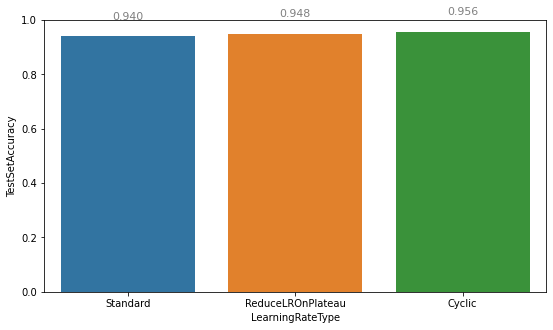

In [97]:
plt.figure(figsize=(9,5))
g = sns.barplot(x="LearningRateType", y="TestSetAccuracy", data=results_df)

ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,1) #To make space for the annotations

In [ ]:
cyclical_learning_rate_first = CyclicalLearningRate(
 initial_learning_rate=(1e-4),
 maximal_learning_rate=(1e-3),
 step_size=step_size,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

In [36]:
# Iteration 1
optimizer = tf.keras.optimizers.Adam(learning_rate = cyclical_learning_rate_first,amsgrad = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
vgg_cyclic_extra = createVGG16Model(X_train,12)

vgg_cyclic_extra.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history_cyclic_first = vgg_cyclic_extra.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=60, validation_data=(X_val, y_val),
                               callbacks=[early_stopping])

Epoch 1/60
1815/1815 [==============================] - 124s 68ms/step - loss: 0.3535 - accuracy: 0.9026 - val_loss: 0.1749 - val_accuracy: 0.9513
Epoch 2/60
1815/1815 [==============================] - 123s 68ms/step - loss: 0.2314 - accuracy: 0.9418 - val_loss: 0.1684 - val_accuracy: 0.9563
Epoch 3/60
1815/1815 [==============================] - 125s 69ms/step - loss: 0.2204 - accuracy: 0.9453 - val_loss: 0.1681 - val_accuracy: 0.9572
Epoch 4/60
1815/1815 [==============================] - 126s 69ms/step - loss: 0.1822 - accuracy: 0.9550 - val_loss: 0.1398 - val_accuracy: 0.9650
Epoch 5/60
1815/1815 [==============================] - 128s 70ms/step - loss: 0.1281 - accuracy: 0.9679 - val_loss: 0.1051 - val_accuracy: 0.9735
Epoch 6/60
1815/1815 [==============================] - 129s 71ms/step - loss: 0.0920 - accuracy: 0.9769 - val_loss: 0.0915 - val_accuracy: 0.9757
Epoch 7/60
1815/1815 [==============================] - 129s 71ms/step - loss: 0.0783 - accuracy: 0.9805 - val_loss: 0

In [45]:
#newww
preds_extra = vgg_cyclic_extra.evaluate(x= test_x, y=test_labels,  batch_size=128)
print()
print ("Loss = " + str(preds_extra[0]))
print ("Test Accuracy = " + str(preds_extra[1]))

204/204 [==============================] - 5s 22ms/step - loss: 0.1581 - accuracy: 0.9657

Loss = 0.15806366503238678
Test Accuracy = 0.9656960368156433


In [57]:
cyclical_learning_rate_next = CyclicalLearningRate(
 initial_learning_rate=(2e-5),
 maximal_learning_rate=(1e-4),
 step_size=step_size,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

In [61]:
#Copying the weights to start the new iteration with reduced cyclical learning rate
vgg_next_iter = keras.models.clone_model(vgg_cyclic_extra)

vgg_next_iter.set_weights(vgg_cyclic_extra.get_weights())

In [62]:
#Iteration 2
optimizer = tf.keras.optimizers.Adam(learning_rate = cyclical_learning_rate_next,amsgrad = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

vgg_next_iter.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history_cyclic_next = vgg_next_iter.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=60, validation_data=(X_val, y_val),
                               callbacks=[early_stopping])

Epoch 1/60
1815/1815 [==============================] - 123s 68ms/step - loss: 0.0317 - accuracy: 0.9928 - val_loss: 0.1184 - val_accuracy: 0.9757
Epoch 2/60
1815/1815 [==============================] - 127s 70ms/step - loss: 0.0304 - accuracy: 0.9933 - val_loss: 0.1209 - val_accuracy: 0.9753
Epoch 3/60
1815/1815 [==============================] - 129s 71ms/step - loss: 0.0312 - accuracy: 0.9929 - val_loss: 0.1233 - val_accuracy: 0.9751
Epoch 4/60
1815/1815 [==============================] - 130s 72ms/step - loss: 0.0297 - accuracy: 0.9931 - val_loss: 0.1227 - val_accuracy: 0.9751
Epoch 5/60
1815/1815 [==============================] - 130s 72ms/step - loss: 0.0218 - accuracy: 0.9949 - val_loss: 0.1331 - val_accuracy: 0.9757
Epoch 6/60
1815/1815 [==============================] - 130s 72ms/step - loss: 0.0176 - accuracy: 0.9962 - val_loss: 0.1390 - val_accuracy: 0.9762
Epoch 7/60
1815/1815 [==============================] - 131s 72ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0

In [63]:
preds_next_iter = vgg_next_iter.evaluate(x= test_x, y=test_labels,  batch_size=128)
print()
print ("Loss = " + str(preds_next_iter[0]))
print ("Test Accuracy = " + str(preds_next_iter[1]))

204/204 [==============================] - 4s 21ms/step - loss: 0.2098 - accuracy: 0.9667

Loss = 0.20981155335903168
Test Accuracy = 0.9666948318481445


In [84]:
result = {'Accuracy' : [], 'Type' : ['Train','Test','Train','Test'], 'CyclicIteration': [1,1,2,2]}

result['Accuracy'].append(history_cyclic_history_cyclic_first.history['accuracy'][-1])
result['Accuracy'].append(preds_extra[1])

result['Accuracy'].append(history_cyclic_next.history['accuracy'][-1])
result['Accuracy'].append(preds_next_iter[1])




In [85]:
results = pd.DataFrame(result)
results

,Accuracy,Type,CyclicIteration
0,0.989133,Train,1
1,0.965696,Test,1
2,0.997107,Train,2
3,0.966695,Test,2


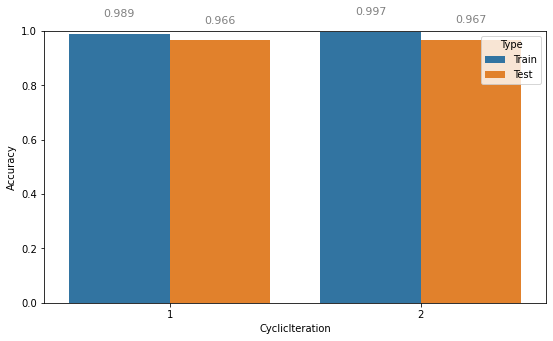

In [87]:
plt.figure(figsize=(9,5))
g = sns.barplot(x="CyclicIteration", y="Accuracy", hue = 'Type', data=results)

ax=g

for p in ax.patches:
             ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,1) 